In [74]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch import device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)
from dataclasses import dataclass
import math
torch.set_float32_matmul_precision('high')



Using device: cuda


## Model Architecture

In [75]:
@dataclass
class gpt2config:
    n_vocab: int = 50257
    n_layer: int = 12
    n_embed: int = 128
    n_context: int = 1024
    n_head: int = 8
    n_timesteps: int = 1000


In [76]:
class GPT2Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_attn = nn.Linear(config.n_embed, 3 * config.n_embed)
        self.c_proj = nn.Linear(config.n_embed, config.n_embed)
        self.n_head = config.n_head
        self.n_embed = config.n_embed
        
        # Create a causal mask (lower triangular matrix) and register it as a buffer
        # A buffer is not a parameter, but is saved with the model state_dict
        self.register_buffer("bias", torch.tril(torch.ones(config.n_context, config.n_context))
                                     .view(1, 1, config.n_context, config.n_context))

    def forward(self, x):
        B, T, C = x.size()
        
        # Calculate query, key, values for all heads in batch
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embed, dim=2)
        
        # Reshape for multi-head attention: (B, nh, T, hs)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # Scaled dot-product attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / (k.size(-1) ** 0.5))
        
        # --- MASKING STARTS HERE ---
        # Apply the causal mask: fill "future" positions with -infinity
        # This makes their softmax probability zero.
        # att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        # --- MASKING ENDS HERE ---

        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, hs)
        
        # Re-assemble all head outputs side-by-side
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        
        # Output projection
        y = self.c_proj(y)
        return y
    
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embed, 4*config.n_embed)
        self.act = nn.GELU(approximate="tanh")
        self.c_proj = nn.Linear(4*config.n_embed, config.n_embed)

    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        return x
    

class Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        
        self.ln1 = nn.LayerNorm(config.n_embed,eps=1e-5,elementwise_affine=True)
        self.attn = GPT2Attention(config)
        self.ln2 = nn.LayerNorm(config.n_embed,eps=1e-5,elementwise_affine=True)
        self.mlp = GPT2MLP(config)

    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


In [77]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1) #
        # TODO: Double check the ordering here
        return embeddings

In [78]:
sine_embeds = SinusoidalPositionEmbeddings(100)
time = 10
time = torch.tensor([time], device=device)
out = sine_embeds(time)
out.shape

torch.Size([1, 100])

In [79]:
class LMEmbedding(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config

        self.embed = nn.Embedding(config.n_vocab,config.n_embed)
    
    def forward(self,input_ids):
        x = self.embed(input_ids)
        
        return x
        


In [80]:
class Denoiser(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            # wte = nn.Embedding(config.n_vocab,config.n_embed),
            wpe = nn.Embedding(config.n_context,config.n_embed),
            drop = nn.Dropout(0.1,inplace=False),
            h = nn.ModuleList(Block(config) for _ in range(config.n_layer)),
            ln_f = nn.LayerNorm(config.n_embed,eps=1e-5,elementwise_affine=True)
        ))
        
        # self.lm_head = nn.Linear(config.n_embed, config.n_vocab, bias=False)

        self.small_mlp = nn.Linear(config.n_embed, config.n_embed)

        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(config.n_embed),
            nn.Linear(config.n_embed, config.n_embed),
            nn.GELU()
            )

    def forward(self,input_embeddings,time_step, targets=None):
        B,T,C = input_embeddings.size()
        device = input_embeddings.device

        pos = torch.arange(0,T,dtype=torch.long,device=device).unsqueeze(0)  # (1,T)
        x = input_embeddings +  self.transformer.wpe(pos)  # (B,T,C) pytorch does braodcasting for the position embeddingss and adds them to the token embeddings 
        
        time_emb = self.time_embed(time_step) # (B, C)
        x= x + time_emb.unsqueeze(1)  # (B, T, C)
        
        x = self.transformer.drop(x)


        for block in self.transformer.h:
            x = block(x)

        x = self.transformer.ln_f(x)  # (B,T,C)
        # logits = self.lm_head(x)  # (B,T,vocab_size) 
        # we don't need the head since we are not doing autoregressive language modeling
        
        # we want to predict the starting sequence before the noising part.
        x = self.small_mlp(x)  # (B,T,C)
        
        return x

In [81]:
class Decoding(nn.Module):
    def __init__(self,config):
        super().__init__()
    # takes x0 (B,T,C) and give a softmax over vocab size           
        self.l1 = nn.Linear(config.n_embed, config.n_vocab, bias=False)
        
        
    def forward(self,x):
        x = self.l1(x)
        # x = F.softmax(x,dim=-1)

        return x

In [82]:
class DiffusionLM(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.embedding = LMEmbedding(config)
        self.denoiser = Denoiser(config)
        self.decoder = Decoding(config)
        
    def forward(self,input_ids,time_step, targets=None):
        input_embeddings = self.embedding(input_ids)  # (B,T,C)
        x = self.denoiser(input_embeddings,time_step, targets)  # (B,T,C)
        logits = x@self.embedding.embed.weight.T  # (B,T,vocab_size)
        
        return x, logits

## Tokenizer

In [146]:
import tiktoken

# 1. Load the tokenizer for GPT-4o

def encode(text, max_len):
    ids = tokenizer.encode(text, allowed_special=set())   # normal tokens only
    ids = [special_tokens["<bos>"]] + ids + [special_tokens["<eos>"]]

    if len(ids) > max_len:
        ids = ids[:max_len]
        ids[-1] = special_tokens["<eos>"]
    else:
        ids += [special_tokens["<pad>"]] * (max_len - len(ids))
    return ids



class MyTokenizer:
    def __init__(self, max_len):
        tokenizer = tiktoken.get_encoding("r50k_base")
        self.special_tokens = {
            "<pad>": tokenizer.n_vocab,
            "<bos>": tokenizer.n_vocab + 1,
            "<eos>": tokenizer.n_vocab + 2,
        }

        self.tokenizer = tiktoken.Encoding(
            name="r50k_base_ext",
            pat_str=tokenizer._pat_str,
            mergeable_ranks=tokenizer._mergeable_ranks,
            special_tokens=self.special_tokens,
        )
        self.n_vocab = self.tokenizer.n_vocab 
        self.max_len = max_len

    @staticmethod
    def clean_text(text):
        for tok in ("<pad>", "<bos>", "<eos>"):
            text = text.replace(tok, "")
        return text
    
    def encode(self, text,max_len=None):
        if max_len is None:
            max_len = self.max_len
        text = self.clean_text(text)
        ids = self.tokenizer.encode(text, allowed_special=set())
        ids = [self.special_tokens["<bos>"]] + ids + [self.special_tokens["<eos>"]]

        if len(ids) > max_len:
            ids = ids[:max_len]
            ids[-1] = self.special_tokens["<eos>"]
        else:
            ids += [self.special_tokens["<pad>"]] * (max_len - len(ids))
        return ids  

    def decode(self, ids):
        
        return self.tokenizer.decode(ids)


In [147]:
tokenizer = MyTokenizer(max_len=13)

In [148]:
tokenizer.decode(tokenizer.encode("Hello, tiktoken is fast!"))

'<bos>Hello, tiktoken is fast!<eos><pad><pad><pad>'

In [149]:
config = gpt2config(n_vocab=tokenizer.n_vocab)
model = DiffusionLM(config).to(device)
print(f"Total Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
print(config.n_vocab)

Total Model parameters: 15.41M
50260


## Testing Initialization

In [150]:
sample_input = "Once upon a time in a land far away, there lived a"
sample_tokens = tokenizer.encode(sample_input)
sample_input_ids = torch.tensor([sample_tokens], device=device)  # (1, sequence_length)
sample_time_step = torch.tensor([10], device=device)  # (1,)

In [151]:
sample_input_ids.shape

torch.Size([1, 13])

In [153]:
sample_output, sample_logits = model(sample_input_ids, sample_time_step)  # (1, sequence_length, n_embed)

def finalize_tokens(x0_final, embedding_weights):
    """
    Converts the final denoised latent into discrete token IDs.
    Args:
        x0_final: Tensor of shape (B, T, C)
        embedding_weights: Tensor of shape (Vocab, C)
    """
    # Fix: x2 must be 3D to match x1 (B, T, C)
    # Unsqueeze(0) makes it (1, Vocab, C), and PyTorch broadcasts it to (B, Vocab, C)
    distances = torch.cdist(x0_final, embedding_weights.unsqueeze(0), p=2) #(B,T,Vocab)  
    token_ids = torch.argmin(distances, dim=-1) #(B, T)
    
    return token_ids

token_ids = finalize_tokens(sample_output, model.embedding.embed.weight)
decoded_output = tokenizer.decode(token_ids.squeeze(0).tolist())
print("Decoded Text:",decoded_output)



Decoded Text:  Dum discontineksenziedata havingenzieotinedataainerotine twentieth Created


## Forward Diffusion

In [154]:
def get_alphas(T=2000, s=1e-4):
    """
    Computes the bar_alpha (signal) schedule for Diffusion-LM[cite: 232, 483].
    s: constant determining initial noise level (standard dev = 0.1)[cite: 515].
    """
    t = torch.linspace(0, T, T + 1)
    # Sqrt schedule: alpha_bar = 1 - sqrt(t/T + s) 
    alphas = 1 - torch.sqrt(t / T )
    
    return alphas

In [155]:
def fwd_diffusion(x0, t, alphas):
    """
    Directly samples x_t from x_0 at a specific timestep[cite: 109, 170].
    
    Args:
        x0: Clean embeddings (B, SeqLen, EmbedDim) [cite: 126]
        t: Timesteps for the batch (B,) 
        alphas: Precomputed signal schedule from get_alphas()
    """
    # Select alpha_bar for each batch item and reshape for broadcasting
    a = alphas[t].view(-1, 1, 1).to(x0.device)
    
    # Sample Gaussian noise with same shape as x0
    noise = torch.randn_like(x0)
    
    # Formula: x_t = sqrt(alpha_bar) * x0 + sqrt(1 - alpha_bar) * noise [cite: 169]
    print("sqrt a avg:",torch.sqrt(a).mean())
    xt = torch.sqrt(a) * x0 + torch.sqrt(1 - a) * noise
    
    return xt

In [156]:
alphas = get_alphas().to(device)

noisy_input = fwd_diffusion(model.embedding(sample_input_ids), torch.tensor([1000], device=device), alphas)

sqrt a avg: tensor(0.5412, device='cuda:0')


In [157]:
F.mse_loss(noisy_input,sample_output)

tensor(1.2866, device='cuda:0', grad_fn=<MseLossBackward0>)

In [158]:

token_ids = finalize_tokens(noisy_input, model.embedding.embed.weight)
decoded_output = tokenizer.decode(token_ids.squeeze(0).tolist())
print("Decoded Text:",decoded_output)

Decoded Text: <bos>Once upon a time in a land far away, there<eos>


## Loading Datasets

In [168]:
import pandas as pd

# Load E2E dataset - extract text from 'ref' column
df = pd.read_csv('datasets/e2e-dataset/trainset.csv')
text = ' '.join(df['ref'].tolist())

print(f"Dataset length: {len(text)} characters")
print(f"Number of samples: {len(df)}")
print(f"First sample: {df['ref'][0]}")

Dataset length: 4646702 characters
Number of samples: 42061
First sample: The Vaults pub near Café Adriatic has a 5 star rating.  Prices start at £30.


In [169]:
# Split into train and test
train_size = int(0.9 * len(df))
train_df = df[:train_size].reset_index(drop=True)
test_df = df[train_size:].reset_index(drop=True)

print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

Train samples: 37854, Test samples: 4207


In [170]:
# Data loader function
def get_batch(split, batch_size=8, block_size=256, device=device):
    # Select the appropriate dataframe
    data_df = train_df if split == 'train' else test_df
    
    # Randomly sample batch_size indices
    indices = torch.randint(0, len(data_df), (batch_size,))
    
    # Get the text sequences and encode them
    sequences = []
    for idx in indices:
        text = data_df['ref'].iloc[idx.item()]
        encoded = tokenizer.encode(text, max_len=block_size)
        sequences.append(encoded)
    
    # Stack into tensor
    w_stack = torch.tensor(sequences, device=device)
    return w_stack

# Test batch
w_stack = get_batch('train', batch_size=4, block_size=64, device='cpu')
print(f"Batch shape: {w_stack.shape}")
print(f"First sequence decoded: {tokenizer.decode(w_stack[0].tolist())}")

Batch shape: torch.Size([4, 64])
First sequence decoded: <bos>The Rice Boat, located in the riverside area has average customer views. The child friendly restaurant serves English food.<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


## Training Loop


In [171]:
from torch.optim.lr_scheduler import LambdaLR

In [172]:
# Training configuration
max_iters = 30000  
learning_rate = 1e-4
eval_iters = 500  # Much fewer eval iterations (was 200!)
batch_size = 32  # Larger batch for better GPU utilization
sequence_length = 64
T = 1000
num_timestep_samples = 16  # Sample 8 timesteps per iteration for better gradient estimate

# alphas = get_alphas(T=T,s=1e-4).to(device)

In [173]:
# Fixed alpha schedule - simple sqrt schedule
t = torch.arange(0, T+1, device=device, dtype=torch.float32)
alpha_bars = 1 - torch.sqrt(t / T)  # Goes from ~0 to 1-sqrt(1)=0
alpha_bars = torch.clamp(alpha_bars, min=0.01, max=0.999)
alphas = torch.zeros(T+1, device=device) #alpha_0 to alpha_T
alphas[0] = alpha_bars[0]
alphas[1:] = alpha_bars[1:] / alpha_bars[:-1]
alphas = torch.clamp(alphas, min=0.01, max=0.999)

# Precompute sqrt terms for efficiency
sqrt_ab = torch.sqrt(alpha_bars)
sqrt_1mab = torch.sqrt(1 - alpha_bars)

print(f"Alpha bars range: [{alpha_bars.min():.4f}, {alpha_bars.max():.4f}]")
print(f"Alphas range: [{alphas.min():.4f}, {alphas.max():.4f}]")


Alpha bars range: [0.0100, 0.9990]
Alphas range: [0.9521, 0.9990]


In [174]:
def posterior_mean(x_t, x0, t, alpha_bars,alphas):
    abar_t = alpha_bars[t]
    abar_tm1 = alpha_bars[t-1] if t > 0 else torch.tensor(1.0, device=x_t.device)
    # print(abar_t,abar_tm1)
    coef1 = torch.sqrt(abar_tm1) * (1 - alphas[t]) / (1 - abar_t)
    coef2 = torch.sqrt(alphas[t]) * (1 - abar_tm1) / (1 - abar_t)
    # print("coef1 avg:",coef1.mean())
    # print("coef2 avg:",coef2.mean())
    return coef1 * x0 + coef2 * x_t


In [175]:
optimizer_model = torch.optim.AdamW(model.parameters(), lr=learning_rate,weight_decay=0.0)
lr_lambda = lambda step: 1.0 - (step / float(max_iters))
scheduler_model = LambdaLR(optimizer_model, lr_lambda=lr_lambda)

In [176]:
round_start = int(0.2 * max_iters)    # start after geometry is formed
round_warmup = int(0.5 * max_iters)   # ramp over 30% of training
round_max_weight = 0.4
def rounding_weight(it):
    if it < round_start:
        return 0.0
    elif it > round_start + round_warmup:
        return round_max_weight
    else:
        x = (it - round_start) / round_warmup
        return round_max_weight * 0.5 * (1 - math.cos(math.pi * x))

for it in range(0,max_iters):

    w = get_batch('train', batch_size, sequence_length)   # (B,L)
    w_emb = model.embedding(w)                            # (B,L,d)

    # ---- sample x0 with small noise ----
    x0 = w_emb + 0.1 * torch.randn_like(w_emb)

    total_loss = 0.0

    
    # ---- Sample multiple timesteps to approximate E_t[loss] ----
    # This gives a better gradient estimate than sampling just one timestep
    eps = torch.randn_like(x0)
    denoising_loss = 0.0
    for _ in range(num_timestep_samples):
        t_random = torch.randint(1, T+1, (batch_size,), device=device)
        
        # Generate noised version at those timesteps
        t_idx = t_random   # Convert to 0-indexed
        sqrt_ab_t = sqrt_ab[t_idx].view(batch_size, 1, 1)
        sqrt_1mab_t = sqrt_1mab[t_idx].view(batch_size, 1, 1)
        
        xt = sqrt_ab_t * x0 + sqrt_1mab_t * eps
        x0_hat = model.denoiser(xt, t_random)
        
        # Accumulate denoising loss over sampled timesteps
        denoising_loss += F.mse_loss(x0_hat, x0)
    
    # Average over timestep samples
    # denoising_loss = denoising_loss / num_timestep_samples
    total_loss += denoising_loss
    
    # ---- Posterior mean regularization at timestep T ----
    # Sample at the final timestep T
    t_T = torch.full((batch_size,), T, device=device)
    xT = sqrt_ab[-1] * x0 + sqrt_1mab[-1] * eps
    
    # Predict x0 from xT
    x0_hat_T = model.denoiser(xT, t_T)
    
    # Compute posterior mean and regularize it to be close to zero
    # mu_hat_T = posterior_mean(xT, x0_hat_T, T, alpha_bars)
    mu_hat_T = posterior_mean(xT, x0, T, alpha_bars,alphas)

    posterior_loss = mu_hat_T.pow(2).mean()
    total_loss += posterior_loss
    # posterior_loss = torch.tensor([0],device=device)
    # ---- t=1 anchor loss (every iteration for stability) ----
    # This ensures the denoised output matches actual word embeddings
    xt_1 = sqrt_ab[1] * x0 + sqrt_1mab[1] * torch.rand_like(x0)
    x0_hat_1 = model.denoiser(xt_1, torch.ones(batch_size, device=device))
    anchor_loss = F.mse_loss(x0_hat_1, w_emb)
    total_loss += anchor_loss

    # ---- rounding loss (tied weights) ----
    # Use x0_hat_1 from anchor step for rounding loss
    # logits = torch.matmul(x0_hat_1, model.embedding.embed.weight.T)  # (B,L,V)
    logits = x0_hat_1 @ model.embedding.embed.weight.T

    rounding_loss =  rounding_weight(it) * F.cross_entropy(logits.view(-1, config.n_vocab), w.view(-1))
    total_loss += rounding_loss  # Scale to balance losses
    # rounding_loss =torch.tensor([0],device=device)
    # ----/ optimize ----
    optimizer_model.zero_grad(set_to_none=True)
    total_loss.backward()
    
    # Gradient clipping to prevent exploding gradients
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer_model.step()
    scheduler_model.step()

    if it % eval_iters == 0:
        print(f"Iter {it}: loss = {total_loss.item():.4f}, denoising = {denoising_loss.item():.4f}, posterior = {posterior_loss.item():.4f}, anchor = {anchor_loss.item():.4f}, rounding = {rounding_loss.item():.4f}")


Iter 0: loss = 23.0265, denoising = 20.7757, posterior = 0.9987, anchor = 1.2521, rounding = 0.0000


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    w = get_batch('train', 1, sequence_length)
    x0 = model.embedding(w)
    eps = torch.randn_like(x0)

    for t in [1, T//4, T//2, T]:
        xt = sqrt_ab[t-1] * x0 + sqrt_1mab[t-1] * eps
        print(t, torch.norm(xt - x0).item())


1 0.0
125 64.73625946044922
250 77.60521697998047
500 95.5138168334961


## Inference

In [ ]:
def reverse_diffusion_with_clamping(model, alpha_bars, T, context_length=50, batch_size=1,clamping_start=0.4):

    model.eval()
    
    # Start from pure noise: x_T ~ N(0, I)
    x_t = torch.randn(batch_size, context_length, config.n_embed, device=device)
    with torch.no_grad():
        # Reverse diffusion: t = T, T-1, ..., 1, 0
        for t_step in range(T ,0, -1):
            if t_step % 1 == 0 or t_step == T:
                pass
            else:
                continue 
            
            t_tensor = torch.tensor([t_step] * batch_size, device=device)

            x0_pred = model.denoiser(x_t, t_tensor)
            
            if t_step > clamping_start * T:
                x0_clamped_tokens = finalize_tokens(x0_pred, model.embedding.embed.weight)
                x0_clamped = model.embedding(x0_clamped_tokens)  # (B, T, C)
            else:
                x0_clamped = x0_pred
                        
            epsilon = torch.randn_like(x_t)

            # Compute x_{t-1} using the closed-form update
            x_t = torch.sqrt(alpha_bars[t_step - 1]) * x0_clamped + torch.sqrt(1 - alpha_bars[t_step - 1]) * epsilon
          
            # Convert to tokens using argmin rounding with learned embeddings
            generated_tokens = finalize_tokens(x0_clamped, model.embedding.embed.weight)
            
            # Decode to text
            generated_text = []
            for i in range(batch_size):
                text = tokenizer.decode(generated_tokens[i].tolist())
                generated_text.append(text)
            
            if t_step % 50 == 0 or t_step == T:
                print(f"\nTimestep {t_step}:")
                for i in range(batch_size):
                    print(f"Sample {i+1}: {generated_text[i]}")

    return generated_tokens, generated_text



In [ ]:
print("Starting reverse diffusion inference with clamping...")
context_length = 100
generated_tokens, generated_text = reverse_diffusion_with_clamping(
    model=model,
    alpha_bars=alpha_bars,
    T=T,
    context_length=context_length,
    batch_size=1,
    clamping_start=0.0
)

Starting reverse diffusion inference with clamping...

Timestep 1000:
Sample 1: 
 to a
 his
 was in He.. He to. to to his
 to was He was. his.
 to. to. the to in.. his
 to. was was to the to the to to the was

 to. the..

 was
 to. for. of
 it. of and. on. to for was. She a He. in't., was She, to to, The the. was to
 He in in

Timestep 950:
Sample 1: .. was.... to was
 the to. was the.. to.. to the for..'t
. to in..
 the. to
 to. was.
 was and. to
... to. on to
.... the the to to.,
 the. of in to on the

 the a
 a He., and to.
., to.
, He was was't
 it The the

Timestep 900:
Sample 1: 
 the the to the.... was his..
 to to to
 to.. to in.
 to the to.
 a the the. found the was to
......
 to. a. He to the but. to.. all of. to,. bought at She. on and. not and of all put. it's He for his on in, with She, to on looked, have. of Tom in She it.

Timestep 850:
Sample 1: . to. to to.. the. his.. for. the a.. it. to.. the on. to in. a
 to in the..
.
 the the a to.
 to.. the to.. the to.... the He

## Visualizing the Embedding Space

In [ ]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

def visualize_static_3d(emb_func, vocab_list, top_n=500):
    # 1. Force everything to CPU and Float32 immediately
    embeddings = emb_func.embed.weight[:top_n].detach().cpu().float().numpy()
    
    print(f"Running t-SNE on {top_n} points...")
    # Lower perplexity for fewer points to prevent hanging
    tsne = TSNE(n_components=3, perplexity=min(30, top_n-1), init='pca', verbose=1)
    embeds_3d = tsne.fit_transform(embeddings)

    # 2. Simple Matplotlib 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(embeds_3d[:, 0], embeds_3d[:, 1], embeds_3d[:, 2], alpha=0.6)
    
    # Label a few random points so you can see if words cluster
    for i in range(0, top_n, top_n // 10): 
        ax.text(embeds_3d[i, 0], embeds_3d[i, 1], embeds_3d[i, 2], vocab_list[i])

    plt.title("Static 3D Embedding View")
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

@torch.no_grad()
def visualize_embeddings_2d(emb_func, vocab_list, top_n=5000):
    # 1. Extract and Clean Data
    # Convert to CPU, Float32, and Numpy immediately to prevent hanging
    embeddings = emb_func.weight[:top_n].detach().cpu().float().numpy()
    
    # 2. PCA Pre-reduction (768 -> 50)
    # This removes noise and makes t-SNE significantly faster and more stable
    print("Pre-reducing dimensions with PCA...")
    pca = PCA(n_components=50)
    embeddings_reduced = pca.fit_transform(embeddings)

    # 3. 2D t-SNE
    print(f"Running 2D t-SNE on {top_n} tokens...")
    # perplexity 30 is standard; init='pca' is faster than 'random'
    tsne = TSNE(n_components=2, perplexity=30, init='pca', verbose=1, random_state=42)
    embeds_2d = tsne.fit_transform(embeddings_reduced)

    # 4. Plotting with Matplotlib (Reliable & Fast)
    plt.figure(figsize=(12, 10))
    plt.scatter(embeds_2d[:, 0], embeds_2d[:, 1], alpha=0.5, s=5, c='blue')

    # Label a subset of words to verify clusters
    # We label every 100th word so the plot isn't a mess of text
    for i in range(0, top_n, 100):
        plt.annotate(vocab_list[i], (embeds_2d[i, 0], embeds_2d[i, 1]), 
                     fontsize=8, alpha=0.8, weight='bold')

    plt.title(f"Diffusion-LM Latent Space (Top {top_n} Tokens)")
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
my_vocab_itos_list = [tokenizer.decode([i]) for i in range(config.n_vocab)]

Pre-reducing dimensions with PCA...
Running 2D t-SNE on 3000 tokens...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.000s...
[t-SNE] Computed neighbors for 3000 samples in 0.110s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.931198
[t-SNE] KL divergence after 50 iterations with early exaggeration: 77.182022
[t-SNE] KL divergence after 1000 iterations: 3.352218


/home/utsab/miniconda3/envs/IRL_AGV/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


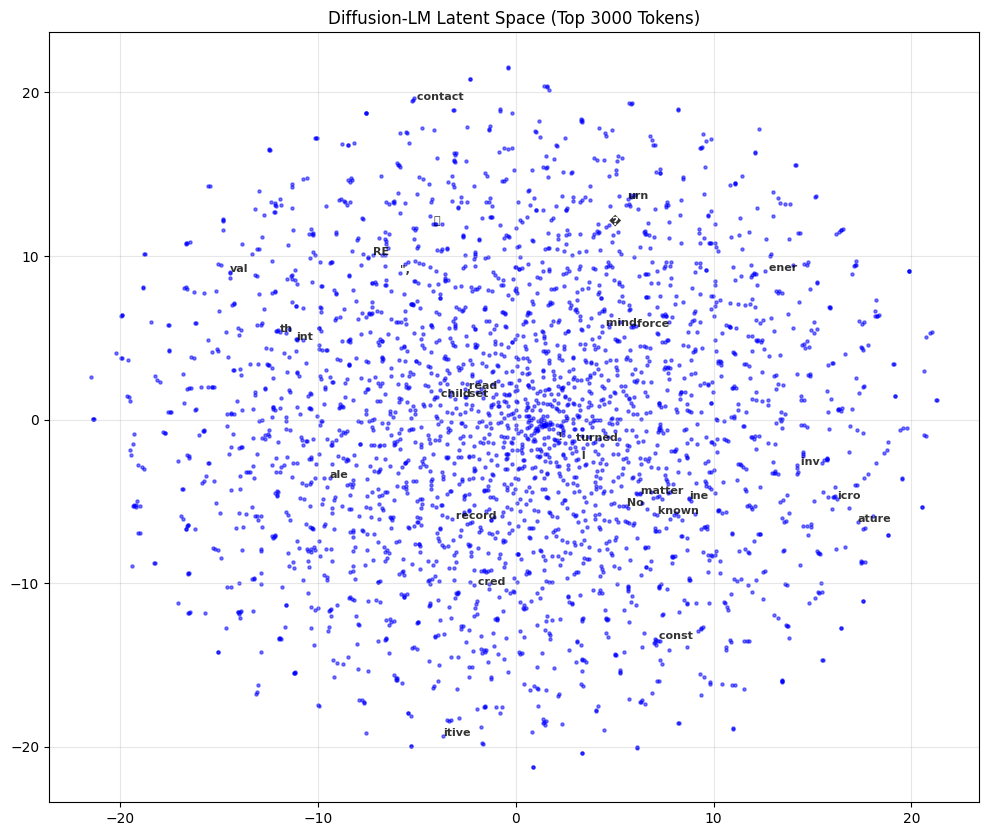

In [ ]:
visualize_embeddings_2d(model.embedding.embed, my_vocab_itos_list[:3000], top_n=3000)

## Saving Model Checkpoints

In [ ]:
# # Save model checkpoints
# import os

# # Create checkpoints directory if it doesn't exist
# checkpoint_dir = 'saved_models/checkpoints__2k_100k_norm'
# os.makedirs(checkpoint_dir, exist_ok=True)

# # Save all three model components
# checkpoint = {
#     'config': config,
#     'emb_func_state_dict': emb_func.state_dict(),
#     'model_state_dict': model.state_dict(),
#     'decoder_state_dict': decoder.state_dict(),
#     'alphas': alphas,
#     'T': T
# }

# checkpoint_path = os.path.join(checkpoint_dir, 'diff_lm_checkpoint.pt')
# torch.save(checkpoint, checkpoint_path)
# print(f"Checkpoint saved to {checkpoint_path}")

# # Optionally, also save individual components
# torch.save(emb_func.state_dict(), os.path.join(checkpoint_dir, 'emb_func.pt'))
# torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'denoiser_model.pt'))
# torch.save(decoder.state_dict(), os.path.join(checkpoint_dir, 'decoder.pt'))
# print("Individual model components saved separately")